# 5.2 Kernel methods in practice
In the current exercise, we will apply the concepts learned about kernel-methods using 4 toy datasets : moons, circles, blobs, and swiss roll. 

__Task__: Using the kernels available in the support vector machine (SVM) implementation found in scikit learn (linear, polynomial, Gaussian, or sigmoid), find the kernel and the corresponding parameter for which SVM achieves the best classification performance. Specifically, experiment with the value of the $\gamma$ parameter, which controls the influence of each of the training samples in the kernel-projection, and therefore, the bias introduced by the kernel used. For further information, see the [scikit learning documentation](http://scikit-learn.org/stable/modules/svm.html#kernel-functions) about the kernels used. Leave the other parameters, as the regularization strength $C$ and the degree of the polynomial kernel fixed.

__Hint 1__: Implement a grid search to find the optimal $\gamma$ value for each of the kernels.

__Hint 2__: Don't forget to use an adequate crossvalidation framework to avoid overfitting.

__Q 5.2.1__ For each of the datasets, what is the kernel with which SVM achieves the best classification performance? What is the corresponding $\gamma$ value?

__Task__: For each of the kernels studied above, find the corresponding K-PCA projection using the same kernel parameters. Visualize the achieved projection and compare the result with projects resulting from using different $\gamma$ values.

__Q 5.2.2__ For each of the datasets, what is the kernel with which the data has the best separability (visual inspection)? What is the corresponding $\gamma$ value? Does the kernel and the $\gamma$ values correspond to the ones for which the performance on __Q 5.2.1__ was the highest?

__Q 5.2.3__ How many components yield K-PCA? How and why is it different from the number of components delivered by PCA?

__BONUS__: Scikit learn provides a method to automatically perform a grid search and find the optimal parameters for a given kernel when training a SVM. Find and use the mentioned method to find the optimal set of parameters for each of the Kernels and datasets. Are the $\gamma$ values the you found for __Q 5.2.1__  and __Q 5.2.2__  similar to the ones yield by the automatic grid search function provided by scikit learn?

In [327]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV as gridS
from sklearn.preprocessing import normalize
from sklearn.decomposition import KernelPCA as kPCA
from sklearn import svm
from tqdm import tqdm

In [185]:
# load data
# Note: The swiss_roll dataset is significantly more computation-intensive than the others.
# You can comment the line below out to speed things up, while you test your approach
datasets = {'moons': [],
           'circles': [],
           'blobs': [],
           'swiss_roll': [], # comment this line out for faster processing
           }


x_m, y_m = np.loadtxt('datasets/moons.data'), np.loadtxt('datasets/moons.labels')
x_c, y_c = np.loadtxt('datasets/circles.data'), np.loadtxt('datasets/circles.labels')
x_b, y_b = np.loadtxt('datasets/blobs.data'), np.loadtxt('datasets/blobs.labels')
x_SR, y_SR = np.loadtxt('datasets/swiss_roll.data'), np.loadtxt('datasets/swiss_roll.labels')

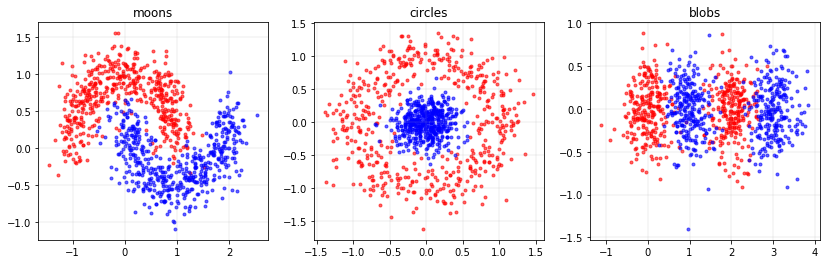

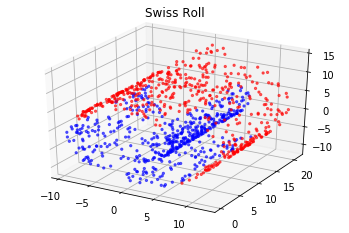

In [245]:
#plotting 2D data
def plot_dat(ax, x, y, t):
    colors = ['r','b']  
    for idx_class in range(2):
        ax.scatter(x[y==idx_class,0],x[y==idx_class,1],  c=colors[idx_class], marker=".", alpha=0.6)
        ax.grid(lw=0.2)
        ax.set_title(t)

f, ax = plt.subplots(1, 3 , figsize=(14, 4))  
for _, x, y ,t in zip(range(3), [x_m, x_c, x_b], [y_m, y_c, y_b], 
                     ["moons", "circles", "blobs"]):
    plot_dat(ax[_], x, y, t)

    
#plotting Swiss Roll    
colors = ['r','b']  
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
for idx_class in range(2):
    cclass = y_SR==idx_class
    ax.scatter(x_SR[cclass,0], x_SR[cclass,1], x_SR[cclass,2], c=colors[idx_class],
              marker=".", alpha=0.6)
    plt.grid(lw=0.3)
    plt.title("Swiss Roll", pad=25)
    plt.draw()

In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


3it [00:07,  2.56s/it]


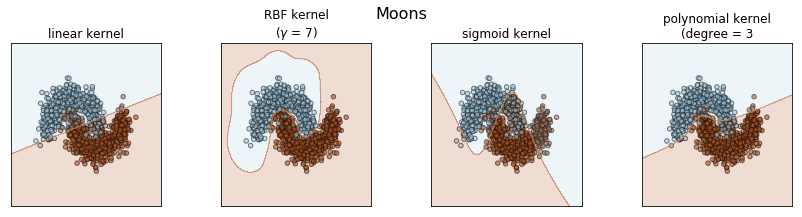

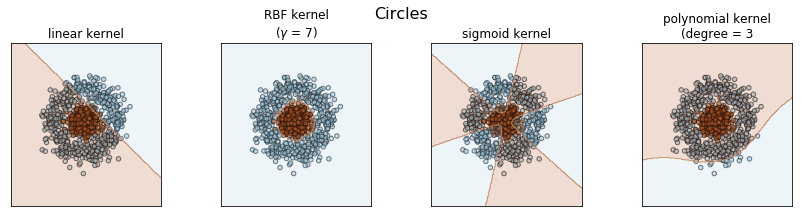

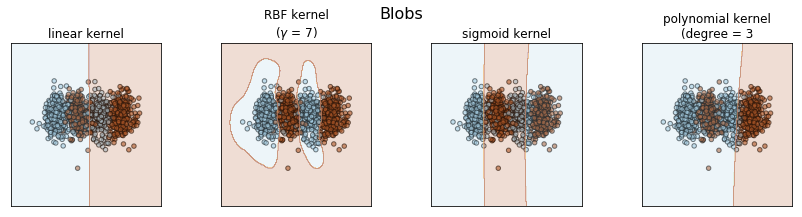

In [311]:
C = 1.0  # SVM regularization parameter
G = 7#'auto'
mdls = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='rbf', gamma=G, C=C),
          svm.SVC(kernel='sigmoid'),
          svm.SVC(kernel='poly', degree=3, gamma=G, C=C))

titles = ('linear kernel',
          'RBF kernel'+"\n("+r"$\gamma$ = "+str(G)+")",          
          'sigmoid kernel',
          'polynomial kernel'+"\n(degree = 3)")



def do_that(X, y, t):   
    
    
    models = (clf.fit(X, y) for clf in mdls)
    
    fig, sub = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.Paired, alpha=0.2 , zorder=2)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.Paired, s=20, edgecolors='k', alpha=0.6, zorder=1)
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        
    fig.add_subplot(111, frameon=False)
    plt.xticks([]); plt.yticks([])
    plt.title(t, pad=25, fontsize=16)
    
for X, y, t in tqdm(zip([x_m, x_c, x_b], [y_m, y_c, y_b], ["Moons", "Circles", "Blobs"])):
    do_that(X, y, t)

plt.show()


Text(0.5, 0, 'gamma')

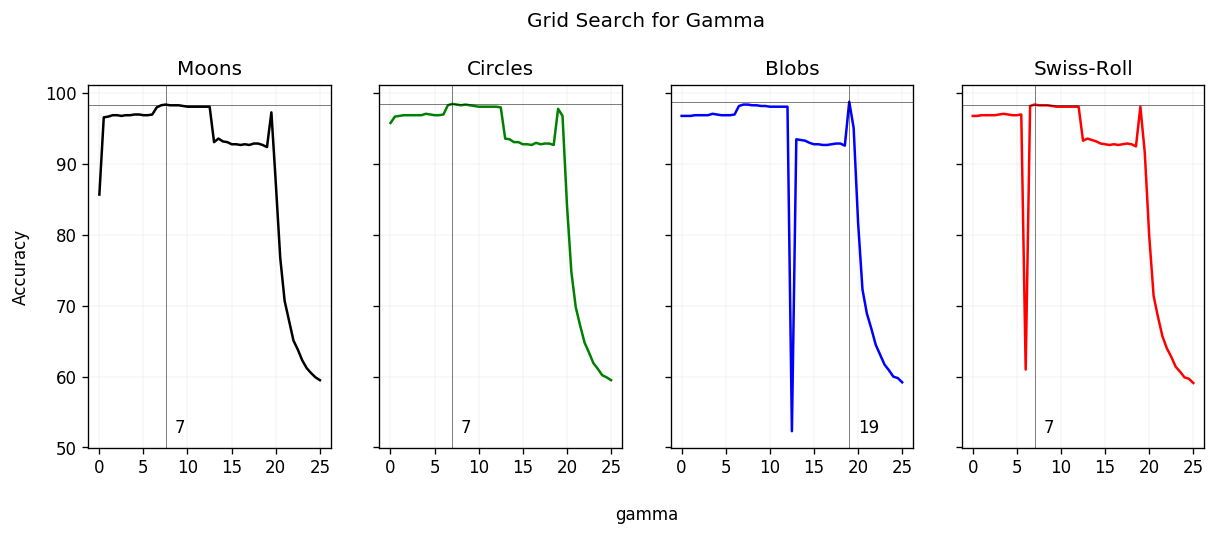

In [306]:
# g=0.5
# print("Accuracy: \n")
# for _, X, y, t in zip(range(4), [x_m, x_c, x_b, x_SR], [y_m, y_c, y_b, y_SR], ["Moons   ", "Circles ", "Blobs   ", "Swiss Roll"]):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
#     svc = svm.SVC(kernel='rbf', gamma=g)
#     svc.fit(X_train, y_train)
#     y_hat = svc.predict(X_test)
#     scores = cross_val_score(svc, X, y)
#     print(str(_+1)+".  "+t+": %0.2f  (+/- %0.2f)" % (100*scores.mean(), 100*scores.std() * 2))

R = np.arange(0.01, 25.5, .5)    
scores = []
for _, X, y, t in zip(range(4), [x_m, x_c, x_b, x_SR], [y_m, y_c, y_b, y_SR], 
                      ["Moons", "Circles", "Blobs", "Swiss-Roll"]):
    for g in R:
        svc = svm.SVC(kernel='rbf', gamma=g)
        svc.fit(X_train, y_train)
        y_hat = svc.predict(X_test)
        scores.append(100*cross_val_score(svc, X, y).mean())
scores = np.array(scores).reshape(len(R), 4)

f, ax = plt.subplots(1, 4, figsize=(12,4), dpi=120, sharey=True, sharex=True)
for _, t, c in zip(range(4), ["Moons", "Circles", "Blobs", "Swiss-Roll"], ["k", "g", "b", "r"]):
    ax[_].plot(R, scores[:,_], c = c )
    ax[_].axvline(R[np.argmax(scores[:, _])], c="k", lw=0.3)
    ax[_].axhline(max(scores[:, _]), c="k", lw=0.3)
    ax[_].text(R[np.argmax(scores[:, _])]+1, 52, str(int(R[np.argmax(scores[:, _])])))
    ax[_].set_xticks(range(0, 30, 5))
    ax[_].grid(lw=0.1)
    ax[_].set_title(t)
f.add_subplot(111, frameon=False)
plt.title("Grid Search for Gamma", pad=35)
plt.xticks([]), plt.yticks([])
plt.ylabel("Accuracy",  labelpad=35)
plt.xlabel("gamma", labelpad=35)

3it [00:04,  1.35s/it]


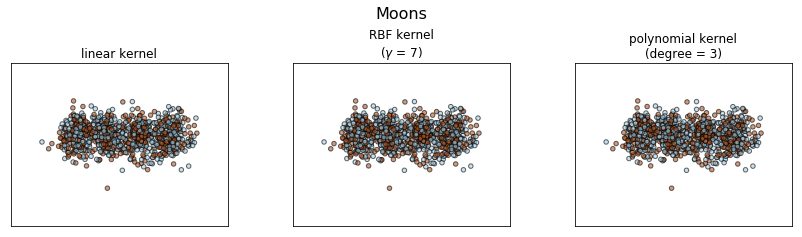

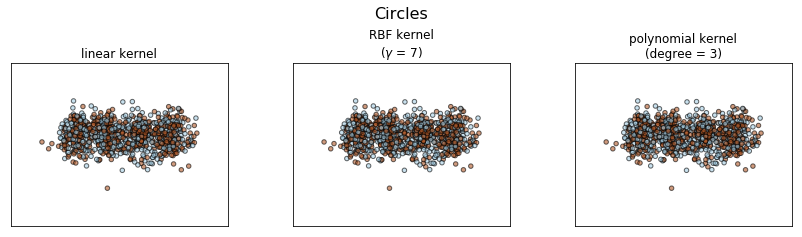

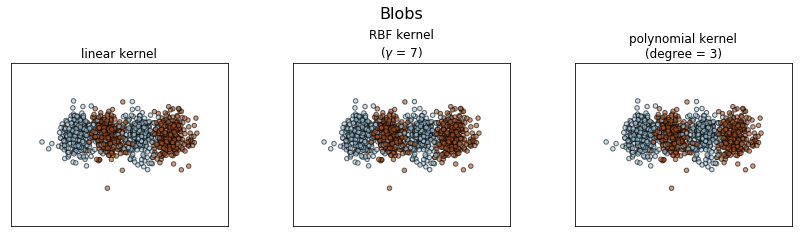

In [324]:
## K-PCA


G = 7#'auto' #<<-- GAMMA

mdls = (kPCA(n_components=7, kernel='linear'),
          kPCA(kernel="rbf", fit_inverse_transform=True, gamma=G),
#           kPCA(kernel='sigmoid'), # <-- leads to non-PSD cov. mat, so causes issues
          kPCA(kernel='poly', degree=3, gamma=G))

titles = ('linear kernel',
          'RBF kernel'+"\n("+r"$\gamma$ = "+str(G)+")",          
#           'sigmoid kernel',
          'polynomial kernel'+"\n(degree = 3)")



def do_that(X, y, t):   
    
    
    models = (k_PCA.fit_transform(X, y) for k_PCA in mdls)
    
    fig, sub = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,3))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
#     X0, X1 = X[:, 0], X[:, 1]
#     xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
#         plot_contours(ax, clf, xx, yy,
#                       cmap=plt.cm.Paired, alpha=0.2 , zorder=2)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.Paired, s=20, edgecolors='k', alpha=0.6, zorder=1)
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        
    fig.add_subplot(111, frameon=False)
    plt.xticks([]); plt.yticks([])
    plt.title(t, pad=45, fontsize=16)
    
for X, y, t in tqdm(zip([x_m, x_c, x_b], [y_m, y_c, y_b], ["Moons", "Circles", "Blobs"])):
    do_that(X, y, t)

plt.show()


In [340]:
## Bonus

# use gridS over hyper-param alpha
def do_gS(X, y):
    parameters = {'kernel':('linear', 'rbf'), 'gamma':[0.1, 25]} # as was set originally
    svc = svm.SVC()
    clf = gridS(svc, parameters)
    clf.fit(X, y)
    gridS(estimator=svm.SVC(), param_grid={'gamma':[0.1, 25], 'kernel': ('linear', 'rbf')})
    return clf.cv_results_['params']
for X, y, t in tqdm(zip([x_m, x_c, x_b], [y_m, y_c, y_b], ["Moons", "Circles", "Blobs"])):
    print(do_gS(X, y))

1it [00:00,  3.04it/s]

[{'gamma': 0.1, 'kernel': 'linear'}, {'gamma': 0.1, 'kernel': 'rbf'}, {'gamma': 25, 'kernel': 'linear'}, {'gamma': 25, 'kernel': 'rbf'}]


2it [00:00,  3.13it/s]

[{'gamma': 0.1, 'kernel': 'linear'}, {'gamma': 0.1, 'kernel': 'rbf'}, {'gamma': 25, 'kernel': 'linear'}, {'gamma': 25, 'kernel': 'rbf'}]


3it [00:01,  2.98it/s]

[{'gamma': 0.1, 'kernel': 'linear'}, {'gamma': 0.1, 'kernel': 'rbf'}, {'gamma': 25, 'kernel': 'linear'}, {'gamma': 25, 'kernel': 'rbf'}]
